In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pylab as plt
plt.style.use('ggplot')
pd.get_option('display.max_rows')

import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
from sklearn.metrics import mean_squared_error
import math

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
base_path = '~/Documents/Kaggle/Python/HousingSalesPrediction'
import os
for dirname, _, filenames in os.walk(base_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [10]:
df = pd.read_csv(base_path+'/data/train.csv')

<a id = "table-of-content"></a>
# Table of Content

- [Business Understanding](#business_undestanding)
- [Data Undestanding](#data_undestanding)
- [Data Preparation](#data_preparation)
- [Modelling](#modelling)
- [Evaluation](#evaluation)
- [Conclusion](#conclusion)
- [References](#references)

In [11]:
from IPython.core.display import display, HTML

toggle_code_str = '''
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
<script>
    function code_toggle() {
        if ($('div.input').css('display')=='none'){
            $('div.input').show();
            $('#toggleButton').val('Hide Code');
        } else {
            $('div.input').hide();
            $('#toggleButton').val('Show Code');
        }
    }
    $( document ).ready(code_toggle);
</script>
'''

# display(HTML(toggle_code_str))


<a id = "biz_understanding"></a>
# Business Undestanding
The ACME Bank would like to understand which factors affect House Sale Prices so that they can focus their advertising efforts.



<a id = "data_understanding"></a>
# Data Understanding
Here we are going to look at the data and hopefully find interesting patterns in it.

There are a few assumptions that we will make and explore the data to see if these assumptions are true.\
Usually when shopping for a house people might consider the following items:
* Construction date
* House area
* Neighbourhood
* Number of rooms
* Parking area

We will try and see if the the above items have a strong correlation to the **SalePrice**

In [12]:
df = pd.read_csv(base_path+'/data/train.csv')
df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [13]:
# df.columns

In [14]:
threshold = 50

The data contains 1460 observations and 81 features and has data types of int64, Objects and float64; there are **43** categorial features with ** null values and **Y** numerical features. There are also **Z** cells that are null. 

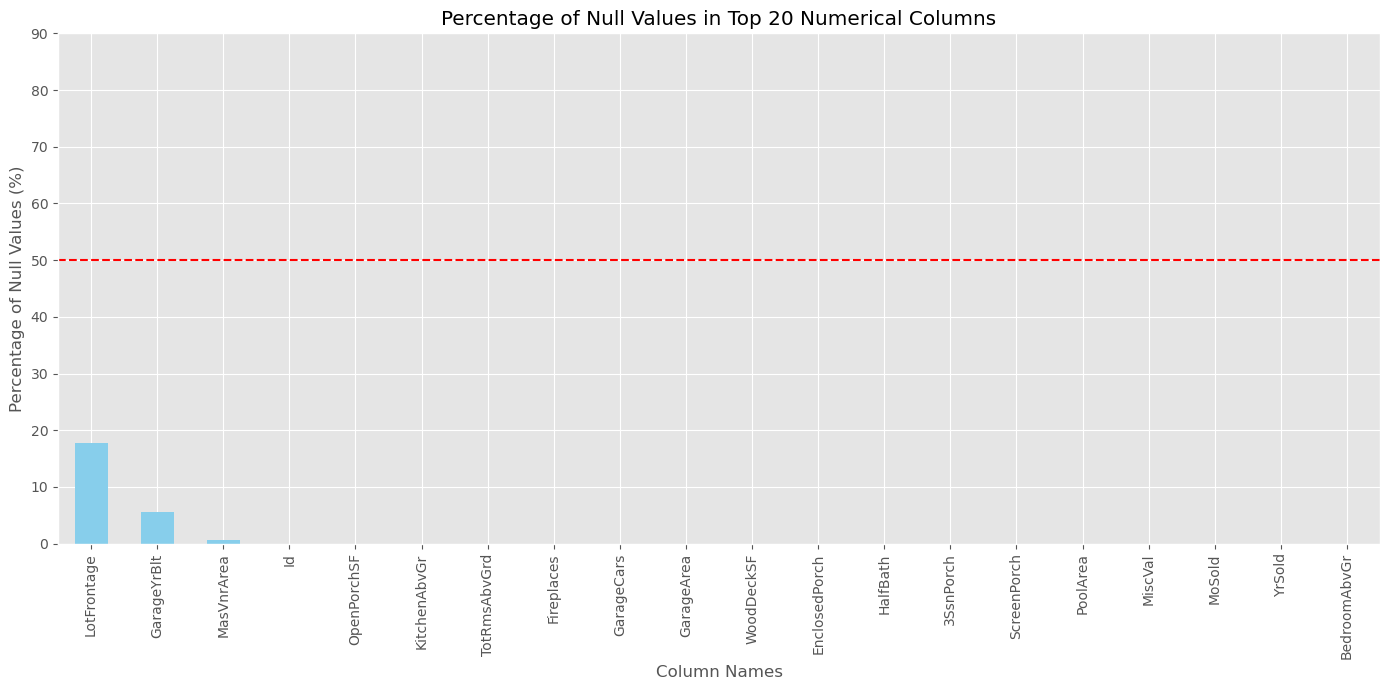

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

df_num = df.select_dtypes(include=['float64', 'int64']).copy()
num_col_names = df_num.columns

# Calculate the percentage of null values for each column
total_rows = len(df_num)
null_counts = df_num.isnull().sum()

# Sort the columns in descending order of null value counts
sorted_null_counts = null_counts.sort_values(ascending=False)

# Select top 20 columns
top_20_null_counts = sorted_null_counts.head(20)

# Calculate percentage for these top 20 columns
top_20_null_percentage = (top_20_null_counts / total_rows) * 100

# Plot
plt.figure(figsize=(14, 7))
top_20_null_percentage.plot(kind='bar', color='skyblue')
plt.title('Percentage of Null Values in Top 20 Numerical Columns')
plt.ylabel('Percentage of Null Values (%)')
plt.yticks(np.arange(0, 100, 10))
plt.axhline(y=threshold, color='r', linestyle='--')  # Here 'r' specifies the color red and '--' specifies a dashed line.
plt.xlabel('Column Names')
plt.tight_layout()
plt.show()

We do not need to drop any numerical columns because the cut off point is we will however impute the null data

In [16]:
## Imputing the nulls for numerical data using kmeans

In [17]:
from sklearn.impute import KNNImputer

# Using KNNImputer

imputer = KNNImputer(n_neighbors=2)
df_num_imputed = pd.DataFrame(imputer.fit_transform(df_num), columns=df_num.columns)
df_num = df_num_imputed
df_num_imputed.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1.0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,...,0.0,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0,208500.0
1,2.0,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,...,298.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0,181500.0
2,3.0,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,...,0.0,42.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0,223500.0
3,4.0,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,...,0.0,35.0,272.0,0.0,0.0,0.0,0.0,2.0,2006.0,140000.0
4,5.0,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,...,192.0,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0,250000.0


## Data Preparation

### Clean Categorical data
Cut of for droping null columns is at 50% +

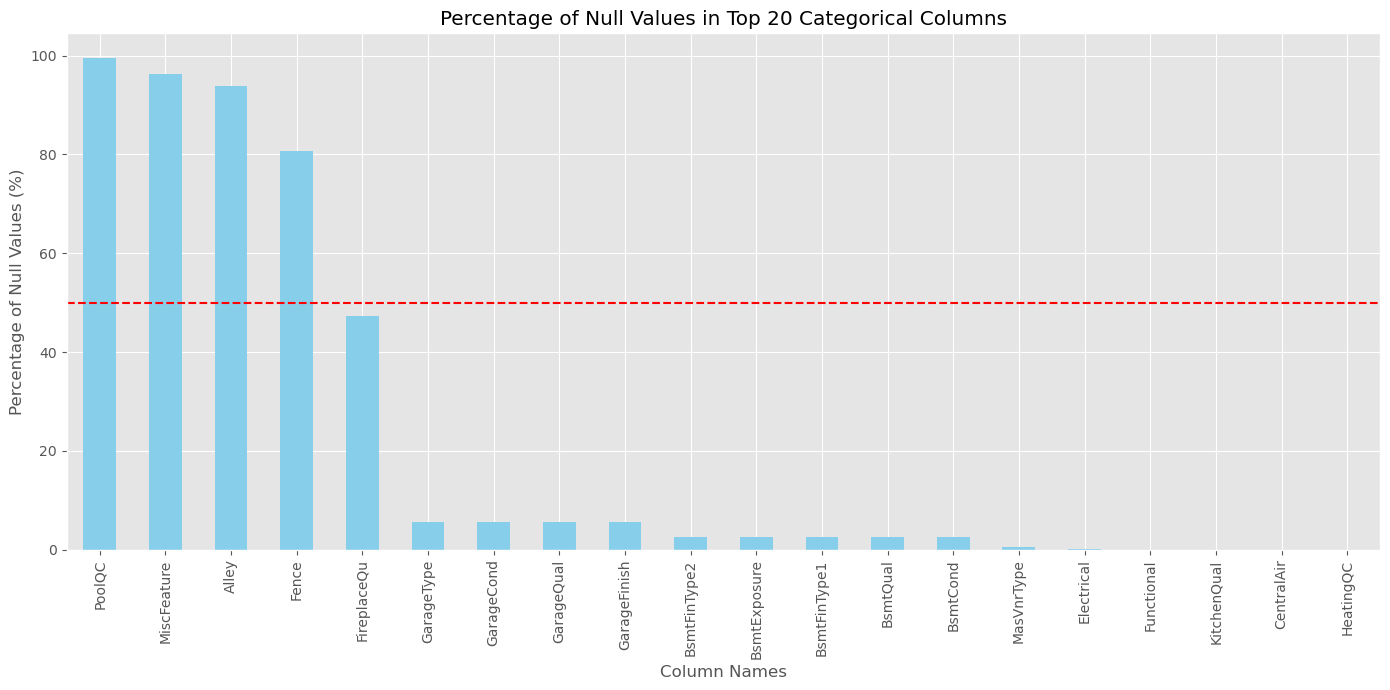

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

df_cat = df.select_dtypes(include=['object', 'O']).copy()
cat_col_names = df_cat.columns

# Calculate the percentage of null values for each column
total_rows = len(df_cat)
null_counts = df_cat.isnull().sum()

# Sort the columns in descending order of null value counts
sorted_null_counts = null_counts.sort_values(ascending=False)

# Select top 20 columns
top_20_null_counts = sorted_null_counts.head(20)

# Calculate percentage for these top 20 columns
top_20_null_percentage = (top_20_null_counts / total_rows) * 100

# Plot
plt.figure(figsize=(14, 7))
top_20_null_percentage.plot(kind='bar', color='skyblue')
plt.title('Percentage of Null Values in Top 20 Categorical Columns')
plt.ylabel('Percentage of Null Values (%)')
plt.axhline(y=threshold, color='r', linestyle='--')  # Here 'r' specifies the color red and '--' specifies a dashed line.
plt.xlabel('Column Names')
plt.tight_layout()
plt.show()

In [19]:
clean_df = df.drop(columns='PoolQC', axis=1).copy()   
clean_df = clean_df.drop(columns='MiscFeature', axis=1)
clean_df = clean_df.drop(columns='Alley', axis=1)
clean_df = clean_df.drop(columns='Fence', axis=1)
# clean_df = df

clean_df.isnull().sum().sort_values(ascending=False)

FireplaceQu     690
LotFrontage     259
GarageType       81
GarageYrBlt      81
GarageFinish     81
               ... 
BsmtUnfSF         0
TotalBsmtSF       0
MSSubClass        0
HeatingQC         0
SalePrice         0
Length: 77, dtype: int64

In [20]:
# from IPython.display import Image
# Image("/Users/wamaebenson/Documents/Kaggle/Python/HousingSalesPrediction/data/images/type_of_test.png")

## Imputing the nulls for categorical data using mode

In [21]:
# null_df.describe()

int64, Object and Float

In [22]:
def mode_impute(variable, impute=False):
#     print('# of missing values: ' + str(df[variable].isna().sum()))
    
    if impute:
        clean_df[variable].replace(np.nan, clean_df[variable].mode()[0], regex=True, inplace=True)
#         print("Imputed: {} for column {}".format(clean_df[variable].mode()[0], variable))

In [23]:
mode_impute('Electrical', impute=True)
mode_impute('Exterior1st', impute=True)
mode_impute('Exterior2nd', impute=True)
mode_impute('LotFrontage', impute=False)

clean_df.isnull().sum().sort_values(ascending=False)


FireplaceQu     690
LotFrontage     259
GarageType       81
GarageYrBlt      81
GarageFinish     81
               ... 
TotalBsmtSF       0
MSSubClass        0
HeatingQC         0
CentralAir        0
SalePrice         0
Length: 77, dtype: int64

### One Hot Encoding 
This will transform all categorical columns into numerical ones

In [24]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False, handle_unknown = "ignore")

X_object = clean_df.select_dtypes(include=['object', 'O'])
ohe.fit(X_object)

codes = ohe.transform(X_object)
# codes.shape
feature_names = ohe.get_feature_names_out(X_object.columns)
# codes
# X_object.shape
# pd.DataFrame(codes,columns=feature_names.reshape(-1))
clean_df = pd.concat([clean_df.select_dtypes(exclude=['object', 'O']), 
               pd.DataFrame(codes,columns=feature_names).astype(int)], axis=1)

clean_df.head(5)


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,0,0,1,0,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,1,0,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,0,0,1,0,0,0,0,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,0,0,1,1,0,0,0,0,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,0,0,0,1,0,0,0,0,1,0


## Statistical Test
We should choose a statistical test for the categorical data so that we can know which columns to drop. Our best choice is to choose the Pearson correlation coefficient after filling in all the nulls, changing categorical data types to numerical ones using one hot encoding and standardizing the data to reduce training time.


In [25]:
# from IPython.display import Image
# Image("/Users/wamaebenson/Documents/Kaggle/Python/HousingSalesPrediction/data/images/type_of_test.png")

### Peason Correlation
The Pearson coefficient is a type of correlation coefficient that represents the relationship between two variables that are measured on the same interval or ratio scale. The Pearson coefficient is a measure of the strength of the association between two continuous variables.

Even with the strong correlations, we must remember that **correlation** is not equal to **cusation**. We will need to look at the p-values to see if they are statistically significant.

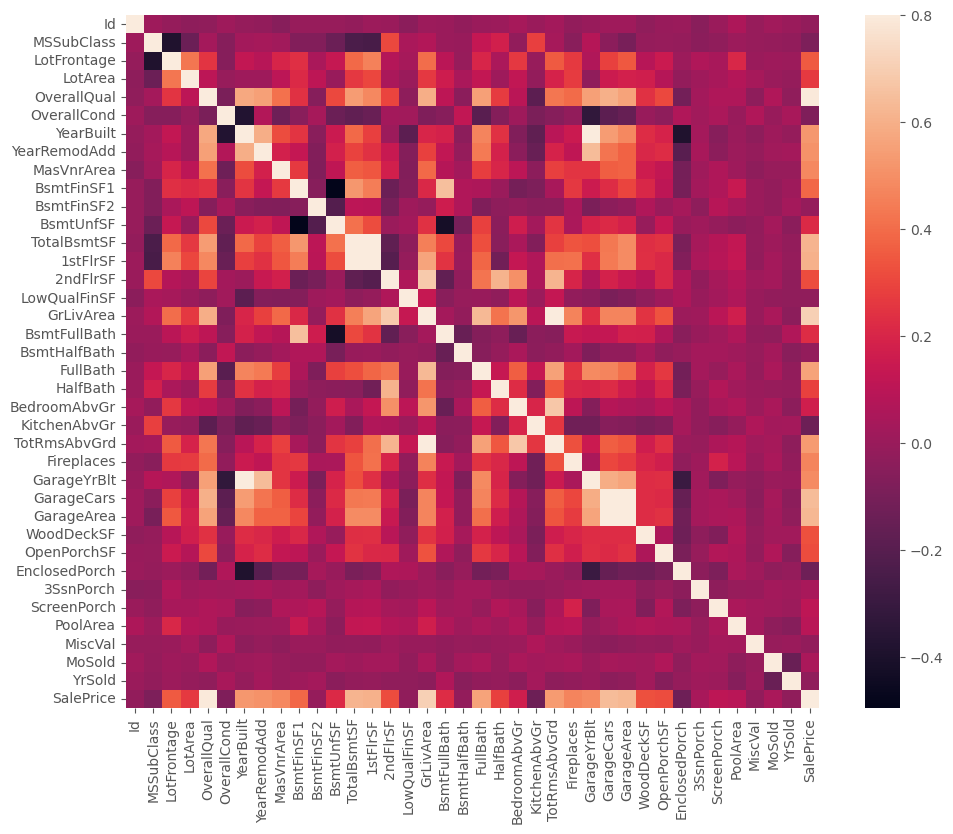

In [26]:
#correlation matrix
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

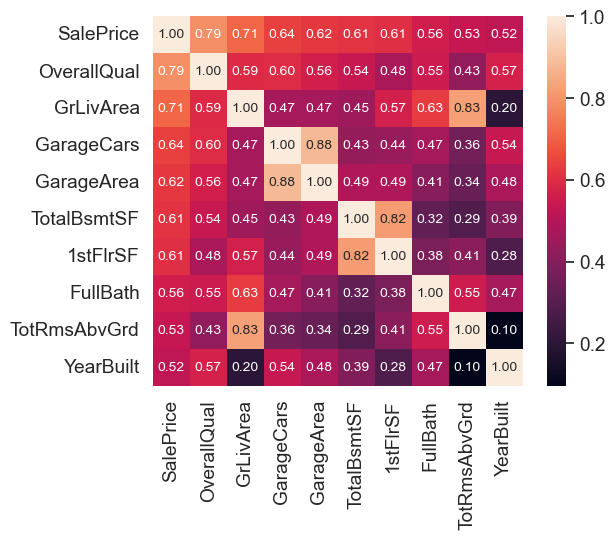

In [27]:
# Compute the Pearson correlation matrix
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Looking at the correlations above we can see that there are a number of colums that have a strong positive correlation with the **SalePrice**.

In [28]:
from scipy.stats import pearsonr

# Compute Pearson correlation coefficient and the p-value
corr_coefficient, p_value = pearsonr(df['SalePrice'].values, df['OverallQual'].values)

print(f"Pearson Correlation Coefficient between OverallQual and SalePrice: {corr_coefficient:.3f}")
print(f"P-value: {p_value:.3f}, which means it is statitically significant")

df['SalePrice'].values

Pearson Correlation Coefficient between OverallQual and SalePrice: 0.791
P-value: 0.000, which means it is statitically significant


array([208500, 181500, 223500, ..., 266500, 142125, 147500])

In [32]:
cat_col_names


Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

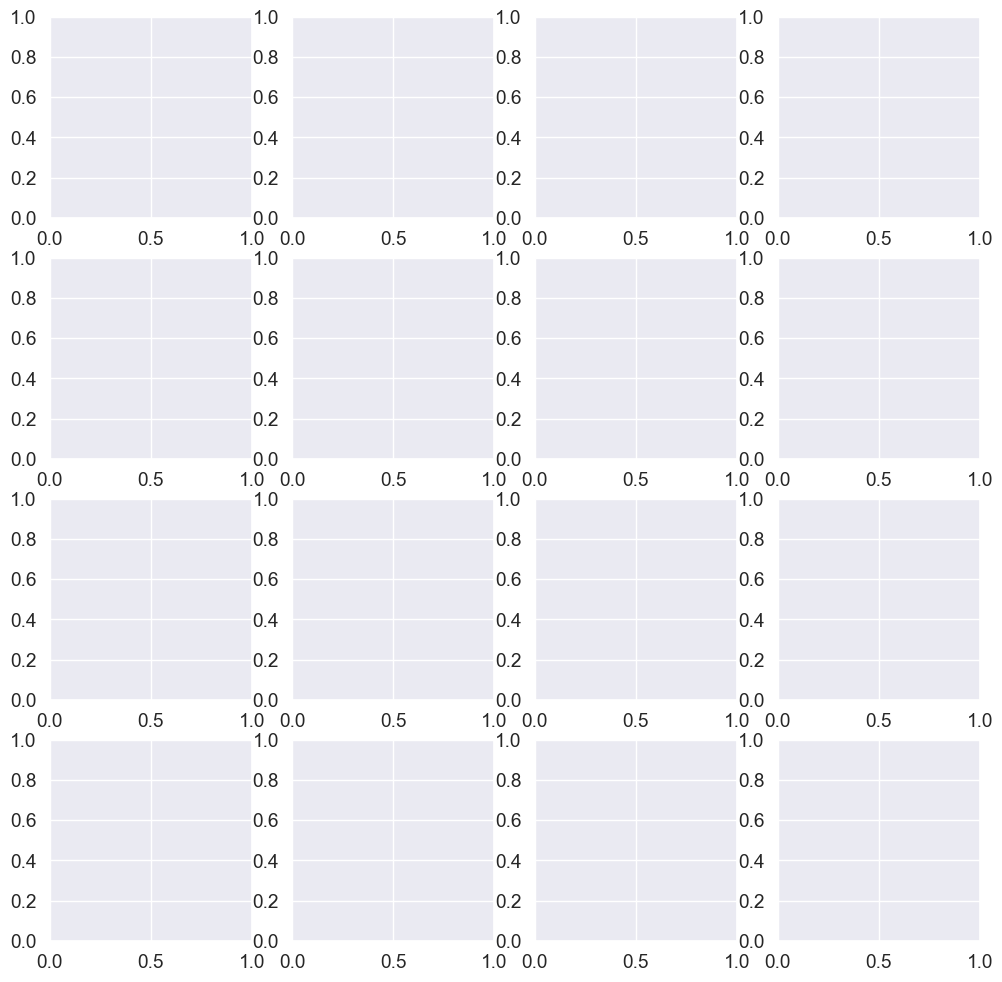

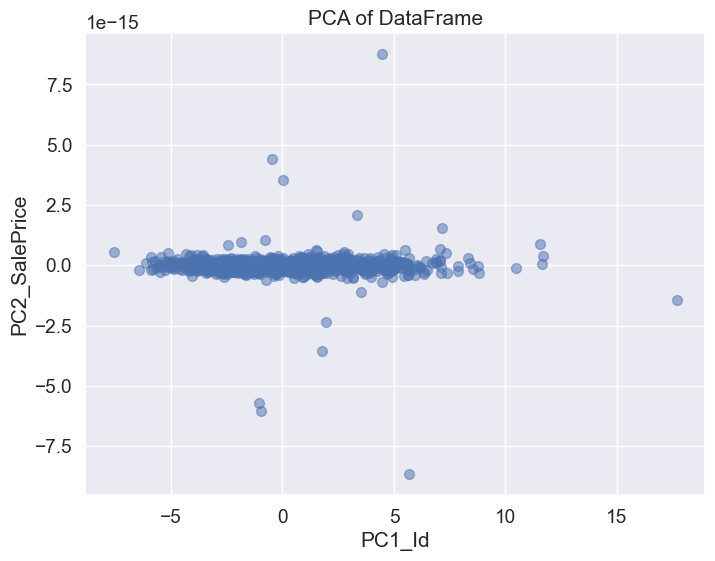

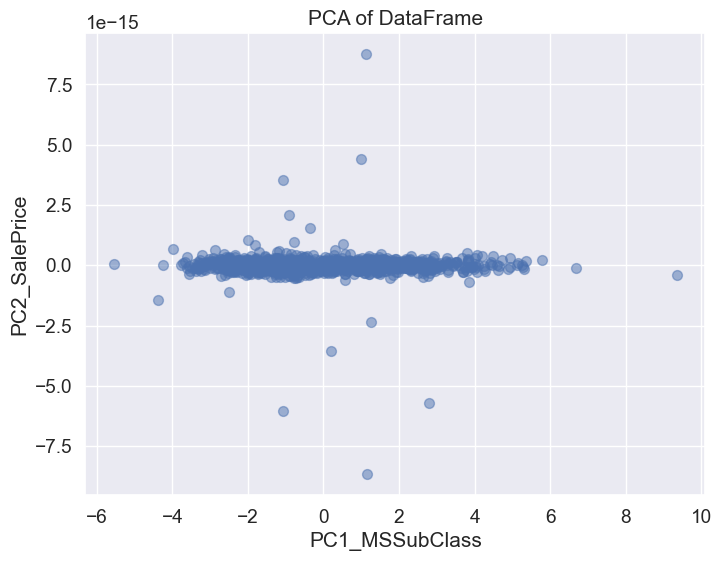

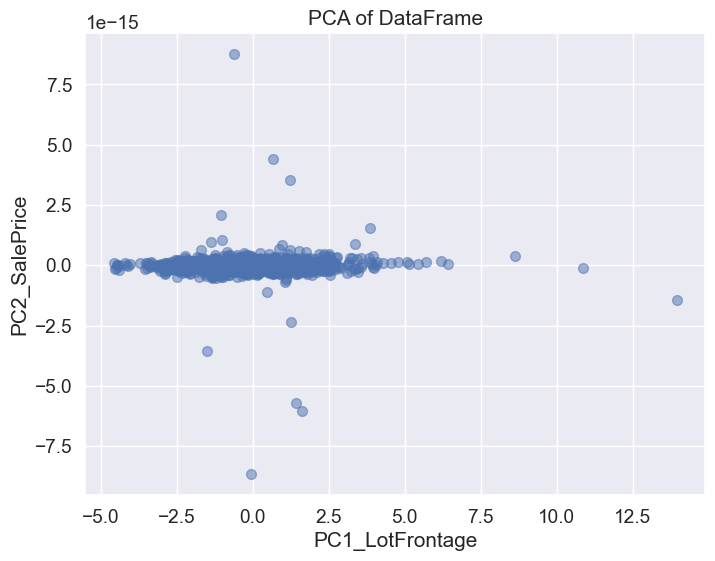

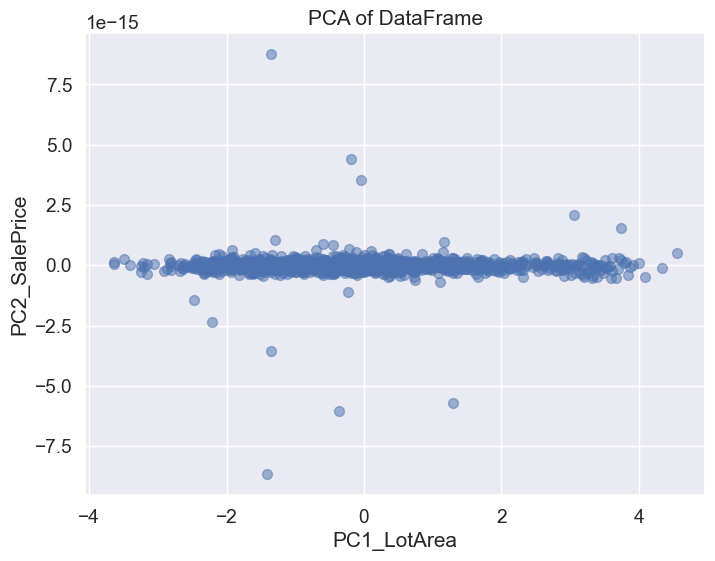

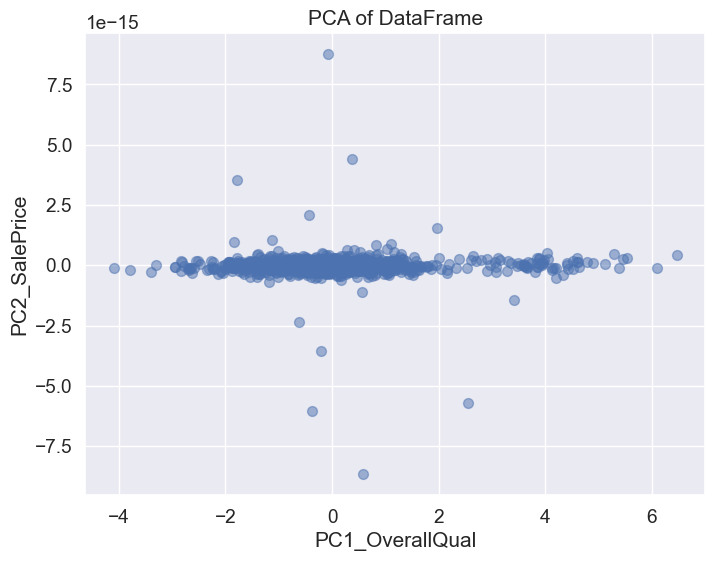

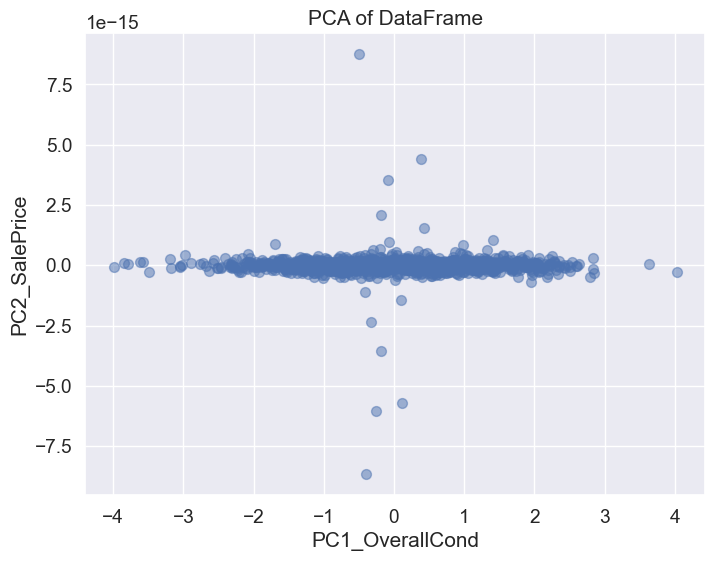

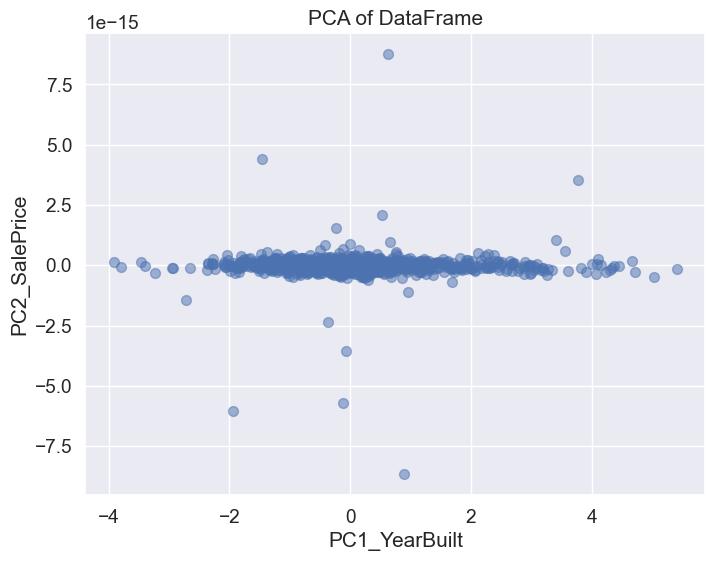

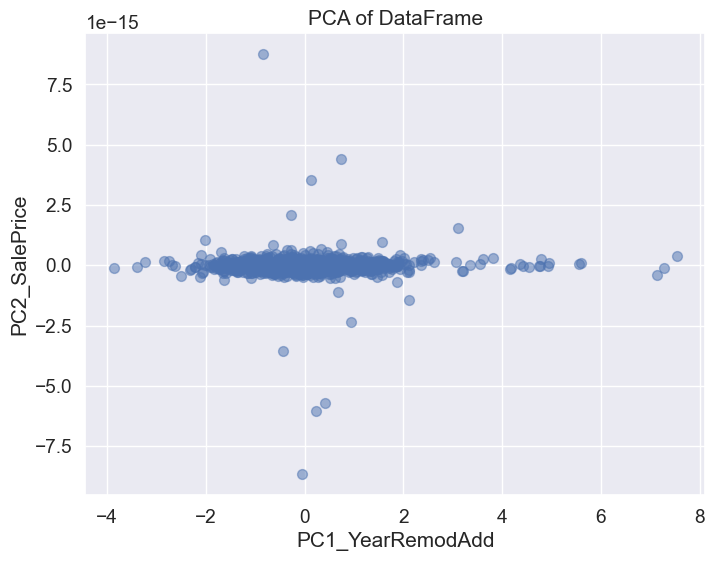

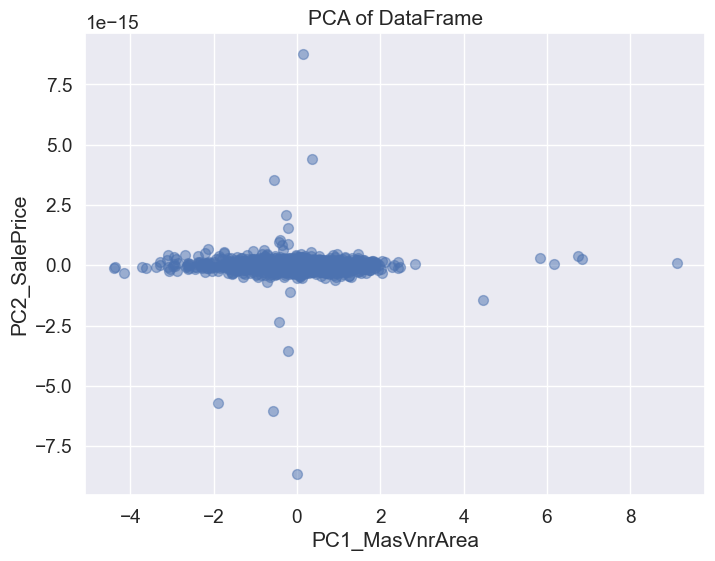

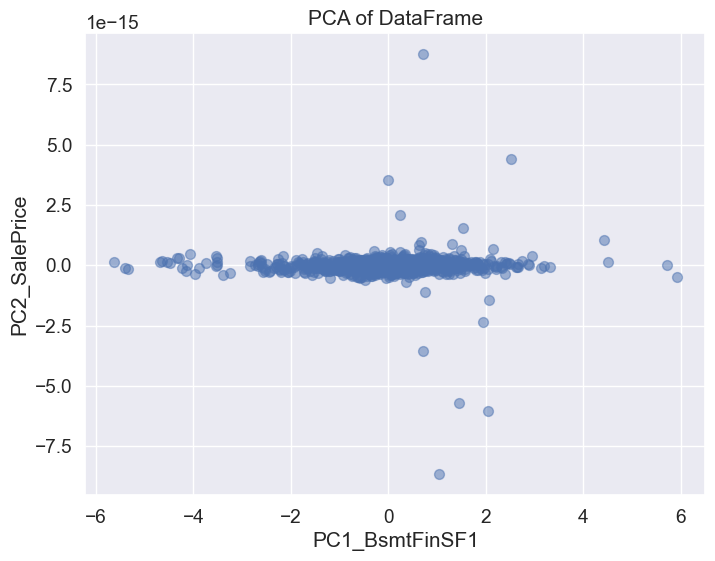

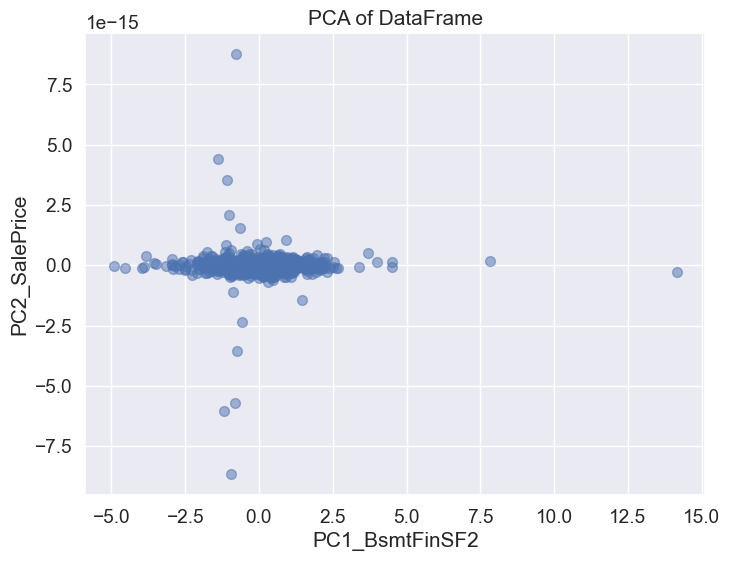

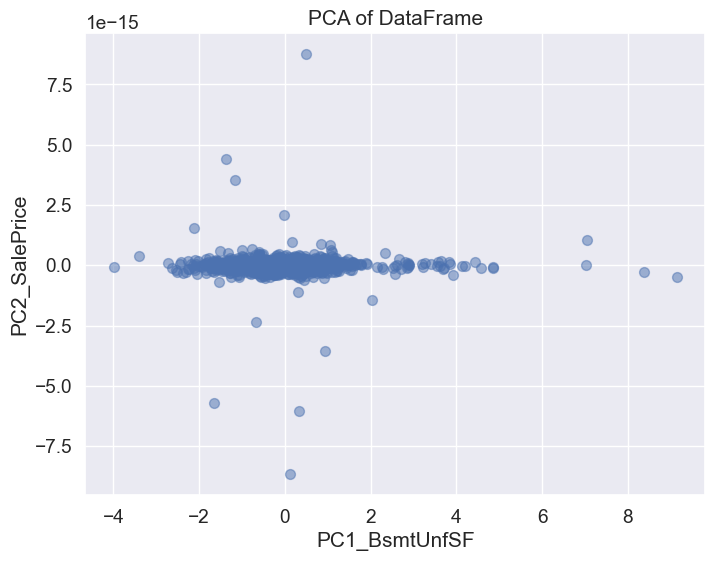

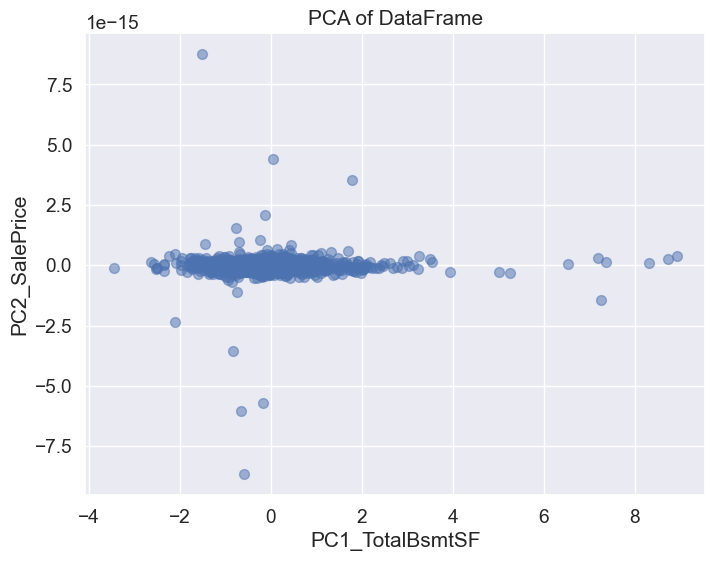

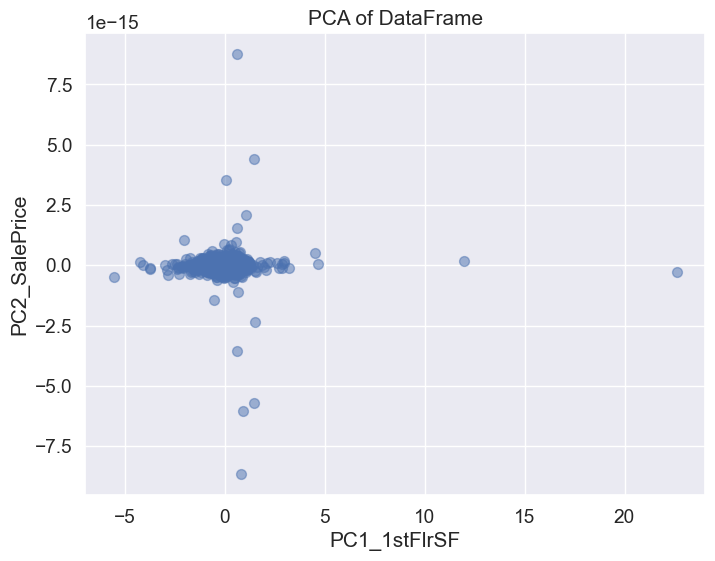

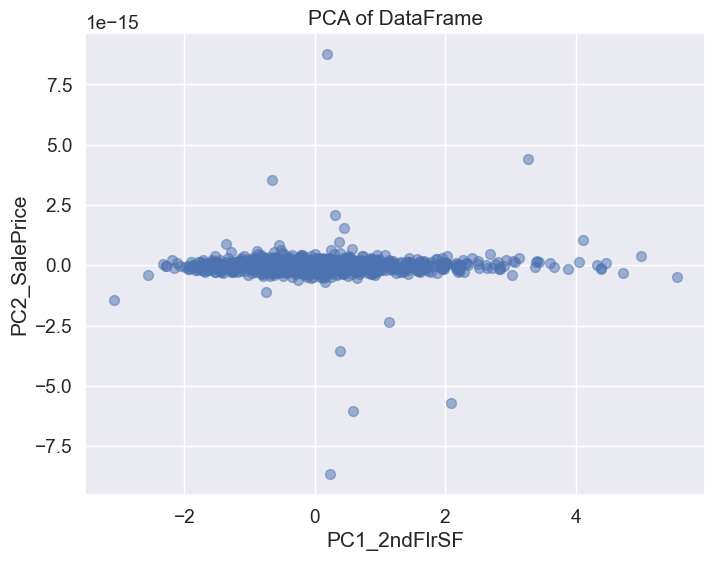

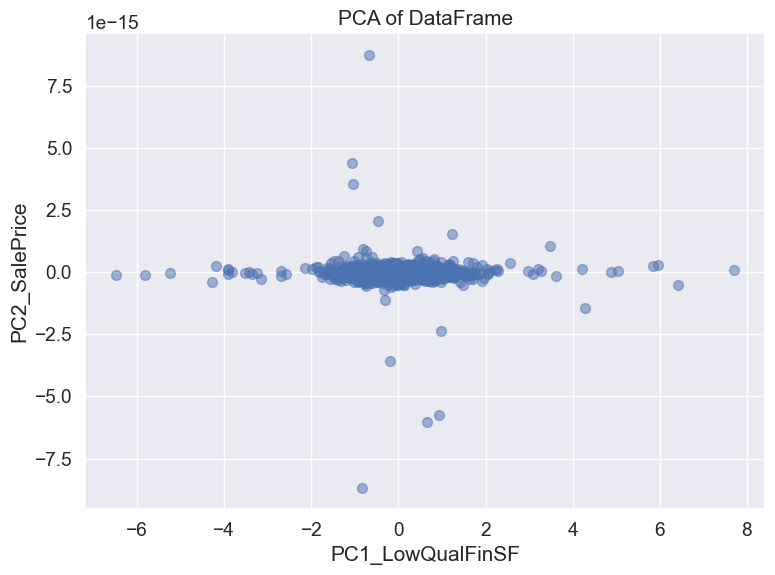

In [50]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. Standardize the data
# PCA is influenced by scale, so it's important to scale features/variables 
# to have a mean = 0 and variance = 1.
scaler = StandardScaler()               # Instantiate the scaler object
scaled_data = scaler.fit_transform(df_num)  # Fit and transform the data


def pca(col_name1, col_name2,col_name3,col_name4):
    # 4. Perform PCA
    # We're reducing data to X principal components for visualization
    pca = PCA(n_components=4)                  # Instantiate PCA object
    principal_components = pca.fit_transform(scaled_data)  # Obtain principal components
    # Create a dataframe with the X components
    principal_df = pd.DataFrame(data=principal_components, columns=[col_name1, col_name2,col_name3,col_name4])
    
#     plt.figure(figsize=(8,6))
#     plt.scatter(principal_df['PC1'], principal_df['PC2'], s=50, alpha=0.5)
#     plt.xlabel('Principal Component 1')
#     plt.ylabel('Principal Component 2')
#     plt.title('PCA of DataFrame')
#     plt.grid(True)
#     plt.show()

    # 5. Visualize the results
    plt.figure(figsize=(8,6))
    plt.scatter(principal_df[col_name1], principal_df['SalePrice'], s=50, alpha=0.5)
    plt.xlabel('PC1')  # x-axis label
    plt.ylabel('PC2')  # y-axis label
    plt.title('PCA of DataFrame')        # Title of the plot
    plt.grid(True)                       # Adding a grid for better readability
    return plt
    plt.show()   
    
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

# Flatten axes for easy iteration
axes_flat = axes.flatten()

def pca(cols):

    # Loop and draw plots
    for ax, column in zip(axes_flat, cols):
         # 4. Perform PCA
        # We're reducing data to X principal components for visualization
        pca = PCA(n_components=cols.size)                  # Instantiate PCA object
        principal_components = pca.fit_transform(scaled_data)  # Obtain principal components
        # Create a dataframe with the X components

        principal_df = pd.DataFrame(data=principal_components, columns=cols)

        plt.figure(figsize=(8,6))
        plt.scatter(principal_df[column], principal_df['SalePrice'], s=50, alpha=0.5)
        plt.xlabel('PC1_'+column)  # x-axis label
        plt.ylabel('PC2_SalePrice')  # y-axis label
        plt.title('PCA of DataFrame')        # Title of the plot
        plt.grid(True) 
    #     ax.set_title(column)

    plt.tight_layout()
    plt.show()
    
 
    
pca(df_num.columns)

In [ ]:
explained_var = pca.explained_variance_ratio_

plt.figure(figsize=(10, 5))
plt.bar(range(1, len(explained_var) + 1), explained_var, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1, len(explained_var) + 1), np.cumsum(explained_var), where='mid', label='cumulative explained variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import pearsonr

# Compute Pearson correlation coefficient and the p-value
corr_coefficient, p_value = pearsonr(df['GrLivArea'], df['1stFlrSF'])

print(f"Pearson Correlation Coefficient between GrLivArea and SalePrice: {corr_coefficient:.3f}")
print(f"P-value: {p_value:.3f}, which means it is statitically significant")

In [ ]:
# Compute the Pearson correlation matrix
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nsmallest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Looking at the correlations above we can see that there are a number of colums that have a strong negative correlation with the **SalePrice**.

In [ ]:
# Compute Pearson correlation coefficient and the p-value
corr_coefficient, p_value = pearsonr(df['KitchenAbvGr'], df['SalePrice'])

print(f"Pearson Correlation Coefficient between col1 and col2: {corr_coefficient:.3f}")
print(f"P-value: {p_value:.3f} it shows it is statistically significant")

In [ ]:
# Convert correlation matrix to HTML
html_table = pd.DataFrame(cm).to_html()

# If you want to view this in a Jupyter notebook directly
# from IPython.core.display import display, HTML
# display(HTML(html_table))

from IPython.core.display import display, HTML
display(HTML(html_table))


Considering we have 1460 rows, we will have to drop some of the null rows/columns 
but before doing that we have to figure out if the nulls mean something or not

Measures of central tendency for **SalePrice**

In [ ]:
df['SalePrice'].describe()

The mean is larger than the median meaning that there are some large values for **SalePrice**.\
These could be outtliers but further investigation is needed

In [ ]:
# TODO: Fix labels on x axis
sns.histplot(df['SalePrice'],kde=True)

In [ ]:
#skewness and kurtosis
print("Skewness: %f" % df['SalePrice'].skew())
print("Kurtosis: %f" % df['SalePrice'].kurt())

The scatter diagram below shows a positive correllation between **GrLivArea** and **SalePrice**.\
There are a few outliers, it is odd that the **GrLivArea** increases but the price stays relatively the same for the outliers.

In [ ]:
#scatter plot grlivarea/saleprice
var = 'GrLivArea'
pd.concat([df['SalePrice'], df[var]], axis=1)
df.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

Select top 7 columns and test them using chi test

Select top 7 columns and test them using chi test

In [ ]:

from sklearn.feature_selection import SelectPercentile
## Selecting the top percentile
selected_top_columns = SelectPercentile(mutual_info_regression, percentile=3)
selected_top_columns.fit(X_train.fillna(0), y_train)

columns = X_train.columns[selected_top_columns.get_support()]
columns = list(columns)
columns


In [ ]:
#scatter plot totalbsmtsf/saleprice
var = 'TotalBsmtSF'
clean_df = pd.concat([df['SalePrice'], df[var]], axis=1)
df.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

The heatmap will allow us to view the different correlations in a much more intuitive way but we must remember **correlation** is not always equal to **causation** and we will have to do othere statistical tests to understand the data further.


In [ ]:
clean_df.columns

In [ ]:
# Create a sample DataFrame
chi_df = pd.DataFrame(clean_df, index=['label1', 'label2'])

# Conduct Chi-squared test
chi2, p, _, _ = chi2_contingency(df)

print(f"Chi-squared value: {chi2}")
print(f"P-value: {p}")

In [ ]:
#correlation matrix
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

We can see here that the following columns have strong correlation to the **SalePrice**
* LotFrontage
* LotArea
* OverrallQual
* YearBuilt
* YearRemodAdd
* MasVnrArea
* BsmtFinSF2
* OpenPorchSF
* WoodDeckSF
* GarageArea
* GarageCars
* GarageYearBlt
* FirePlaces
* TotsRmsAbvGrd
* FullBath
* Halfbath
* GrLivArea
* 1stFlrSF
* 2ndFlrSF
* TotalBsmtSF ...

In [ ]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [ ]:
#Drop to avoid multicolinearlity (Does not apply when using XGBoost)
df = df.drop(['GarageArea'], axis=1)
df = df.drop(['1stFlrSF'], axis=1)

In [ ]:
#deleting outlier points
df.sort_values(by = 'GrLivArea', ascending = False)[:2]
df = df.drop(df[df['Id'] == 1299].index)
df = df.drop(df[df['Id'] == 524].index)

In [ ]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df[cols], height = 2.5)
plt.show();

In [ ]:
#histogram and normal probability plot
from scipy import stats
sns.histplot(df['SalePrice'], kde=True)
plt.tight_layout()
fig = plt.figure()
res = stats.probplot(df['SalePrice'], plot=plt)

We will be applying log transformation to better support the methods we are going to be using

In [ ]:
#applying log transformation
df['SalePrice'] = np.log(df['SalePrice'])

In [ ]:
#transformed histogram and normal probability plot
sns.histplot(df['SalePrice'], kde=True)
fig = plt.figure()
res = stats.probplot(df['SalePrice'], plot=plt)

In [ ]:
#histogram and normal probability plot
sns.histplot(df['GrLivArea'], kde=True);
fig = plt.figure()
res = stats.probplot(df['GrLivArea'], plot=plt)

In [ ]:
#data transformation
df['GrLivArea'] = np.log(df['GrLivArea'])

In [ ]:
#transformed histogram and normal probability plot
sns.histplot(df['GrLivArea'], kde=True);
fig = plt.figure()
res = stats.probplot(df['GrLivArea'], plot=plt)

In [ ]:
#histogram and normal probability plot
sns.histplot(df['TotalBsmtSF'], kde=True);
fig = plt.figure()
res = stats.probplot(df['TotalBsmtSF'], plot=plt)

In [ ]:
#create column for new variable (one is enough because it's a binary categorical feature)
#if area>0 it gets 1, for area==0 it gets 0
df['HasBsmt'] = pd.Series(len(df['TotalBsmtSF']), index=df.index)
df['HasBsmt'] = 0 
df.loc[df['TotalBsmtSF']>0,'HasBsmt'] = 1

In [ ]:
#transform data
df.loc[df['HasBsmt']==1,'TotalBsmtSF'] = np.log(df['TotalBsmtSF'])

In [ ]:
#histogram and normal probability plot
sns.histplot(df[df['TotalBsmtSF']>0]['TotalBsmtSF'], kde=True);
fig = plt.figure()
res = stats.probplot(df[df['TotalBsmtSF']>0]['TotalBsmtSF'], plot=plt)

In [ ]:
#scatter plot
plt.scatter(df['GrLivArea'], df['SalePrice']);

In [ ]:
#scatter plot
plt.scatter(df[df['TotalBsmtSF']>0]['TotalBsmtSF'], df[df['TotalBsmtSF']>0]['SalePrice']);

<a id = "modelling"></a>
# Modelling
We are going to be using XGBoost because it has been shown to effective for such problems.
We will need to use one-hot encoding for the categorical values

In [ ]:

df2 = df.copy()
df2 = df2.drop(['PoolQC', 'MiscFeature', 'Alley','Fence','FireplaceQu','LotFrontage'], axis=1)
# After flattening the data using one-hot encoding some of the columns do not exist in the trees
# We are doing this to remove such columns
# TODO: May be there is a better way of handling this  
               
df2.drop(df2[df2['Condition2'] == 'RRAn'].index, inplace=True)  
df2.drop(df2[df2['Condition2'] == 'RRNn'].index, inplace=True)  
df2.drop(df2[df2['HouseStyle'] == '2.5Fin'].index, inplace=True)          
df2.drop(df2[df2['RoofMatl'] == 'Membran'].index, inplace=True) 
df2.drop(df2[df2['RoofMatl'] == 'Metal'].index, inplace=True) 
df2.drop(df2[df2['RoofMatl'] == 'Roll'].index, inplace=True)  
df2.drop(df2[df2['Exterior1st'] == 'ImStucc'].index, inplace=True)  
df2.drop(df2[df2['Exterior1st'] == 'Stone'].index, inplace=True)  
df2.drop(df2[df2['Exterior2nd'] == 'Other'].index, inplace=True)  
df2.drop(df2[df2['Heating'] == 'Floor'].index, inplace=True)  
df2.drop(df2[df2['Heating'] == 'OthW'].index, inplace=True)  
df2.drop(df2[df2['Electrical'] == 'Mix'].index, inplace=True)  
df2.drop(df2[df2['GarageQual'] == 'Ex'].index, inplace=True)
df2.drop(df2[df2['Utilities'] == 'NoSeWa'].index, inplace=True)
df2.drop(df2[df2['Condition2'] == 'RRAe'].index, inplace=True)
#convert categorical variable into dummy
df_train = pd.get_dummies(df2)
df_train.head()

<a id = "evaluation"></a>
## Evaluation

Here we are splitting our training data to train and test the model

In [ ]:
from sklearn.model_selection import train_test_split
y = df_train['SalePrice']
model_df = df_train.drop(['SalePrice','Id'], axis=1).copy()
X_train, X_test, y_train, y_test = train_test_split(model_df, y)
model_df

We are using Root Mean Squared Error to see how effective the model was at predicting the price

In [ ]:
model = xgb.XGBRegressor(seed = 1444 ,
min_child_weight = 8 ,
max_depth = 3 ,
learning_rate = 0.12570000000000076 ,
gamma = 0.0014900000000000013,early_stopping_rounds=10)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
preds = model.predict(X_test)
print('*'*30)
rmse = round(math.sqrt(mean_squared_error(preds, y_test)),3)
print('RMSE: {}\n'.format(rmse)) 

# Hyperparameter Optimization
Here we are going to be using GridSearchCV and other methods to tune the model's parameters.\
Also we will be trying to see if imputation will improve the model's prediction.


There are no **PoolArea** without **PoolQC** 

In [ ]:
qc = df[df['PoolQC'].isna()]
qc = qc[qc['PoolArea'] > 0]

Replace all null values for Pool Quality (**PoolQC**)

In [ ]:
df['PoolQC'].replace(np.nan, 'None', regex=True, inplace=True)

In [ ]:
df.isna().sum().sort_values(ascending=False)

In [ ]:
df['MiscFeature'].replace(np.nan, 'None', regex=True, inplace=True)
df['Alley'].replace(np.nan, 'None', regex=True, inplace=True)
df['Fence'].replace(np.nan, 'None', regex=True, inplace=True)
df['FireplaceQu'].replace(np.nan, 'None', regex=True, inplace=True)

In [ ]:
garage_categorical = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
for variable in garage_categorical:
    df[variable].replace(np.nan, 'None', regex=True, inplace=True)

Dropped **GarageCars** because it give the same data as **GarageArea**

In [ ]:
df.isna().sum().sort_values(ascending=False)

In [ ]:
garage_numeric = ['GarageYrBlt']

for variable in garage_numeric:
    df[variable].replace(np.nan, 0, regex=True, inplace=True)

In [ ]:
basement_categorical = ['BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
for variable in basement_categorical:
    df[variable].replace(np.nan, 'None', regex=True, inplace=True)

In [ ]:
basement_numeric = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']
for variable in basement_numeric:
    df[variable].replace(np.nan, 0, regex=True, inplace=True)    
    
df['MasVnrType'].replace(np.nan, 'None', regex=True, inplace=True)
df['MasVnrArea'].replace(np.nan, 0, regex=True, inplace=True)

df['Functional'].replace(np.nan, 'Typ', regex=True, inplace=True)

In [ ]:
mode_impute('Electrical', impute=True)
mode_impute('Exterior1st', impute=True)
mode_impute('Exterior2nd', impute=True)per
mode_impute('LotFrontage', impute=False)

In [ ]:
df.isna().sum().sort_values(ascending=False)

In [ ]:
from sklearn.model_selection import train_test_split
y = df_train['SalePrice']
model_df = df_train.drop(['SalePrice','Id'], axis=1).copy()

X_train, X_test, y_train, y_test = train_test_split(model_df, y)
model_df.head()


In [ ]:
X_train.isnull().sum().sort_values(ascending=False)

In [ ]:
X_train = X_train.fillna(0)
X_train.isnull().sum().sort_values(ascending=False)

Here we try to see if selecting the best columns will yield a better RMSE score

In [ ]:
from sklearn.feature_selection import mutual_info_regression
mutual_info = mutual_info_regression(X_train.fillna(0), y_train)
mutual_info

In [ ]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)

In [ ]:
mutual_info.sort_values(ascending=False)[1:20].plot.bar(figsize=(15, 5))

In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency
df_cleaned = df.dropna()
# Create a sample DataFrame
chi_df = pd.DataFrame(X_train, index= columns)

# Conduct Chi-squared test
chi2, p, _, _ = chi2_contingency(chi_df)

print(f"Chi-squared value: {chi2}")
print(f"P-value: {p}")

In [ ]:
# Check row and column sums
print(df.sum(axis=1))  # Row sums
print(df.sum(axis=0))  # Column sums

In [ ]:
# Selection of top X percentile columns in mutual info did not improve the RMSE
# X_train = X_train[columns]
# X_test = X_test[columns]
# X_train

Here we are using grid search CV to find appropriate parameters for our model

In [ ]:
# seed = 1234 ,
# min_child_weight = 4 ,
# max_depth = 3 ,
# learning_rate = 0.1535000000000021 ,
# gamma = 0.0029400000000000003
params={
 "learning_rate"    : np.arange(0.1,0.2, 0.0001),
#  "reg_alpha"    : np.arange(0.09,0.1, 0.001),
 "max_depth"        : [ 2,3,4,5,6],
 "min_child_weight" : [ 2,3,4,5,6,7,8 ],
 "gamma"            : np.arange(0.001,0.003, 0.00001),
#  "colsample_bytree" : np.arange(0.276,0.277, 0.000001),
 "seed": np.linspace(1000, 5000, 10, dtype=int), 
#  "n_estimators": [57,58,69,60],  
#  "reg_lambda": np.arange(1e-05,1.08e-05, 0.00000001), 
#  "subsample": np.arange(0.828,0.83, 0.00001),
#  "booster": ["gblinear","gblinear", "dart"] 
}

In [ ]:
## Hyperparameter optimization using RandomizedSearchCV
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# import xgboost

# def timer(start_time=None):
#     if not start_time:
#         start_time = datetime.now()
#         return start_time
#     elif start_time:
#         thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
#         tmin, tsec = divmod(temp_sec, 60)
#         print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))
        
# classifier=xgboost.XGBRegressor(objective='reg:squarederror')
# random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=10,scoring='neg_mean_squared_error',n_jobs=-1,cv=10,verbose=3)
# from datetime import datetime
# # Here we go
# start_time = timer(None) # timing starts from this point for "start_time" variable
# random_search.fit(X_train,y_train)
# timer(start_time) # timing ends here for "start_time" variable
        
# random_search.best_estimator_

In [ ]:
# random_search.best_params_

In [ ]:
# This makes it eaiser to plug this into the params
def f(dictionary):
    for key in dictionary:
        print(key,'=',dictionary[key],',')

# f(random_search.best_params_)

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import math
# RMSE: 0.11
# seed = 3666 ,
# min_child_weight = 2 ,
# max_depth = 4 ,
# learning_rate = 0.10220000000000007 ,
# gamma = 0.002840000000000005
model = xgb.XGBRegressor(seed = 3666 ,
min_child_weight = 2 ,
max_depth = 4 ,
learning_rate = 0.10220000000000007 ,
gamma = 0.002840000000000005)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
preds = model.predict(X_test)
print('RMSE: {}\n'.format(math.sqrt(mean_squared_error(preds, y_test)))) # 0.12477007481392519 (Before percentiles) 
preds

In [ ]:
from xgboost import plot_importance
plot_importance(model, max_num_features=20) # top 10 most important features
plt.show()

Chi Square tests to see how much of the prediction is explained by x amount of the columns from the above graph

In [ ]:
#Get column names from XGBoost
dtrain = xgb.DMatrix(X_train, label=ytrain, feature_names=feature_names)

df = pd.DataFrame(data, index=['label1', 'label2'])

# Conduct Chi-squared test
chi2, p, _, _ = chi2_contingency(df)

print(f"Chi-squared value: {chi2}")
print(f"P-value: {p}")

In [ ]:
num_records = 200
x = np.linspace(1,364,364)[:num_records]
plt.figure(figsize=(20,6))
plt.title("XGBoost Predicted vs Actual Price (RMSE:{})".format(rmse))
plt.plot(x, y_test[:num_records], label="Actual")
plt.plot(x,preds[:num_records], label="Predicted")
plt.xlabel("Records")
plt.ylabel("Price (log)")
plt.legend(loc="upper left")
plt.show()

## Predicting

### Testing the model with different data (test.csv)

In [ ]:
#  Submission
test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
test_df.head()

In [ ]:
test_df.shape

In [ ]:
test_df.isna().sum().sort_values(ascending=False)

In [ ]:
# df = test_df[['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']]
df_Id = test_df['Id']
df = test_df.drop(['PoolQC', 'MiscFeature', 'Alley','Fence','FireplaceQu','LotFrontage'], axis=1)
#Drop to avoid multicolinearlity
df = df.drop(['GarageArea'], axis=1)
df = df.drop(['1stFlrSF'], axis=1)
df.head()

In [ ]:

#histogram and normal probability plot
sns.histplot(df['GrLivArea'], kde=True)
fig = plt.figure()
res = stats.probplot(df['GrLivArea'], plot=plt)

In [ ]:
#data transformation
df['GrLivArea'] = np.log(df['GrLivArea'])
#transformed histogram and normal probability plot
sns.histplot(df['GrLivArea'], kde=True)
fig = plt.figure()
res = stats.probplot(df['GrLivArea'], plot=plt)

In [ ]:
#histogram and normal probability plot
sns.histplot(df['TotalBsmtSF'], kde=True)
fig = plt.figure()
res = stats.probplot(df['TotalBsmtSF'], plot=plt)

In [ ]:
#create column for new variable (one is enough because it's a binary categorical feature)
#if area>0 it gets 1, for area==0 it gets 0
df['HasBsmt'] = pd.Series(len(df['TotalBsmtSF']), index=df.index)
df['HasBsmt'] = 0 
df.loc[df['TotalBsmtSF']>0,'HasBsmt'] = 1

In [ ]:
#transform data
df.loc[df['HasBsmt']==1,'TotalBsmtSF'] = np.log(df['TotalBsmtSF'])

In [ ]:
#histogram and normal probability plot
sns.histplot(df[df['TotalBsmtSF']>0]['TotalBsmtSF'], kde=True);
fig = plt.figure()
res = stats.probplot(df[df['TotalBsmtSF']>0]['TotalBsmtSF'], plot=plt)

In [ ]:
df2 = df.copy()
# df2.drop(df[df['GarageCond'] == 'Ex'].index, inplace=True)
test_Ids = df2['Id']
df2.drop(['Id'], axis=1, inplace=True)
df_final_test = pd.get_dummies(df2)
df_final_test.columns
df_final_test

In [ ]:
# df_final_test.drop(['GarageCond_Ex'], axis=1, inplace=True)
df_final_test.drop(['GarageCond_Ex'], axis=1, inplace=True)
test_preds = model.predict(df_final_test)
# test_preds
train_columns = df_train.columns.values
test_columns = df_final_test.columns.values
for col in train_columns:
    if col not in df_final_test.columns.values:
        print(col)
print('*'*20)
for col in test_columns:
    if col not in train_columns:
        print(col)

test_preds = np.exp(test_preds)
test_preds

In [ ]:
pred_df = pd.DataFrame(test_preds, index=test_Ids, columns=["SalePrice"])
pred_df.to_csv('output.csv', header=True, index_label='Id')
pred_df

# Deploying model
# TODO: Deploy the model using ?

# References:
* https://www.kaggle.com/code/yaginun/crisp-dm-process-on-the-airbnb-dataset
* https://www.kaggle.com/code/sandhyakrishnan02/normal-distribution-skewness-and-kurtosis

TODO: Add more references